![RISE MICCAI LOGO](https://summer.rise-miccai.org/resources/images/logo.png)

# 👋 Welcome to the RISE-MICCAI Summer School!

We're excited to have you here! In this notebook, you will explore how to work with real chest X-ray data, apply essential preprocessing steps, and prepare the images for machine learning.

**If You’re Using Google Colab (Recommended)** <br>
Google Colab lets you run this notebook in the cloud, with free access to GPUs , no installation required! To get started: Run each code cell using Shift + Enter or by clicking the ▶️ play button on the left.


**If You Prefer to Run Locally** <br>
You will need to create a Python environment and install the required libraries.

Step 1: Create a virtual environment (choose one)

- Using conda:

```conda create -n medical-ai python=3.8``` <br>
```conda activate medical-ai```

- Using venv (built-in):

```python3 -m venv medical-ai``` <br>
```source medical-ai/bin/activate  # or .\medical-ai\Scripts\activate on Windows```

Step 2: Install the required packages <br>
```pip install pydicom albumentations opencv-python scikit-image matplotlib pandas torch torchvision```


Let’s get started 🚀

---

In [1]:
'''Install required packages for the Day 1 Preprocessing notebook.'''

!pip install pydicom albumentations opencv-python scikit-image matplotlib pandas torch torchvision

In [ ]:
'''Download the MIMIC-CXR dataset subset for the summer school.'''

!wget https://mbzuaiac-my.sharepoint.com/:x:/g/personal/shahad_hardan_mbzuai_ac_ae/ETfcvc6fJplIhJQ1QtGO6GgBGRz2pwL3ue-tf90q8uxQtQ?download=1 -O mimic-cxr-subset.csv

!wget https://mbzuaiac-my.sharepoint.com/:u:/g/personal/shahad_hardan_mbzuai_ac_ae/EYhR36CHGUhFoZRD3tGYLU8B65IKnQe_uSx1LM9WTiDFRQ?download=1 -O mimic-cxr.zip mimic-cxr-subset-summer-school.zip

'''Unzip the downloaded zip file. '''

!unzip mimic-cxr.zip -d mimic-cxr-subset-summer-school

--2025-07-14 10:57:52--  https://mbzuaiac-my.sharepoint.com/:x:/g/personal/shahad_hardan_mbzuai_ac_ae/ETfcvc6fJplIhJQ1QtGO6GgBGRz2pwL3ue-tf90q8uxQtQ?download=1
Resolving mbzuaiac-my.sharepoint.com (mbzuaiac-my.sharepoint.com)... 52.107.250.166, 52.107.250.178, 52.107.250.172, ...
Connecting to mbzuaiac-my.sharepoint.com (mbzuaiac-my.sharepoint.com)|52.107.250.166|:443... connected.
HTTP request sent, awaiting response... 302 
Location: /personal/shahad_hardan_mbzuai_ac_ae/Documents/Summer%20School%20-%20MICCAI/MIMIC-CXR/mimic-cxr-subset.csv?ga=1 [following]
--2025-07-14 10:57:53--  https://mbzuaiac-my.sharepoint.com/personal/shahad_hardan_mbzuai_ac_ae/Documents/Summer%20School%20-%20MICCAI/MIMIC-CXR/mimic-cxr-subset.csv?ga=1
Reusing existing connection to mbzuaiac-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 40531 (40K) [application/octet-stream]
Saving to: ‘mimic-cxr-subset.csv’

mimic-cxr-subset.cs 100%[===================>]  39.58K   202KB/s    in 0.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import numpy as np
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Medical Imaging Preprocessing and Data Handling

Preprocessing is a crucial step in medical imaging pipelines that ensures data consistency, enhances image quality, and removes irrelevant variations. When medical images come from hospitals, their raw format might include artifacts, either because of the acquistion machines or the human intervention. In this notebook, you willl explore how preprocessing transforms raw chest X-ray images into a standardized format suitable for building reliable AI models. We will use a subset of the MIMIC-CXR dataset.


## MIMIC - CXR Dataset

Introduction: MIMIC-CXR is a large public dataset of chest X-rays collected from real hospital patients at Beth Israel Deaconess Medical Center. It includes both frontal and lateral chest images, paired with clinical notes and metadata. In this notebook, we focus on a subset of frontal images labeled with pulmonary edema severity for machine learning tasks. The dataset has four classes of patients having 1) no edema, 2) vascular congestion, 3) interstitial edema, and 4) alveolar edema.

Reference: https://physionet.org/content/mimic-cxr/2.1.0/

By the end of this notebook, you will:

- Understand the structure of medical imaging datasets like MIMIC-CXR.
- Load and visualize DICOM chest X-ray images.
- Apply image preprocessing steps like intensity clipping, resizing, and normalization.
- Implement data augmentation to improve generalization.
- Build a custom PyTorch Dataset for model training.
- Explore traditional feature extraction methods like ORB and GLCM.
- Learn how preprocessing and features affect downstream AI models in healthcare.

## Task 1: Understanding the Data Structure

In [ ]:
# Load the CSV file
MIMIC_CXR_METADATA_PATH = './mimic-cxr-subset.csv'
df = pd.read_csv(MIMIC_CXR_METADATA_PATH)

# Show the first few rows
df.head()

,subject_id,study_id,dicom_id,edema_severity,fold
0,10039360,53999249,6b2e134c-da7d94d2-61b74f39-a0149009-edcd3e02,1,3
1,10130348,57511959,c23640ba-9a3fc83e-df6f06f2-9244d819-275ef0b3,0,1
2,10154271,51768020,c92820ab-86ca072a-cb979fed-e8a9b8f0-2e1b4472,1,2
3,10170334,50465091,41eb4980-c532d3f5-25e1b923-6696c9fa-b9e26262,0,3
4,10228186,57118202,621d8f8d-5a467b27-77152e93-31311462-b5921953,0,5


As you can see in the dataset below, it includes dicom_id of patients, but what are DICOM images?

The Digital Imaging and Communications in Medicine (DICOM) Standard specifies a non-proprietary data interchange protocol, digital image format, and file structure for biomedical images and image-related information.

DICOM files contain not only the medical image but also important metadata. This metadata helps provide clinical context and is often used in preprocessing or filtering. Here are a few common examples:

- `Patient ID ((0010,0020))`: A unique identifier for the patient the image belongs to.
- `Modality ((0008,0060))`: The type of imaging device used (e.g., X-ray, CT, MRI).
- `Study Date ((0008,0020))`: The date when the imaging study was performed.

Reference: Bidgood, W. D., Jr, Horii, S. C., Prior, F. W., & Van Syckle, D. E. (1997). Understanding and using DICOM, the data interchange standard for biomedical imaging. Journal of the American Medical Informatics Association : JAMIA, 4(3), 199–212. https://doi.org/10.1136/jamia.1997.0040199

In [ ]:
'''Now let us further explore the dataset.'''

# Number of total images
print(f"Total images: {len(df)}")

# Unique patients
print(f"Unique patients: {df['subject_id'].nunique()}")

# Unique studies
print(f"Unique studies: {df['study_id'].nunique()}")

# Number of images per patient
images_per_patient = df.groupby('subject_id')['dicom_id'].count()
print(f"Images per patient (min/max): {images_per_patient.min()} / {images_per_patient.max()}")

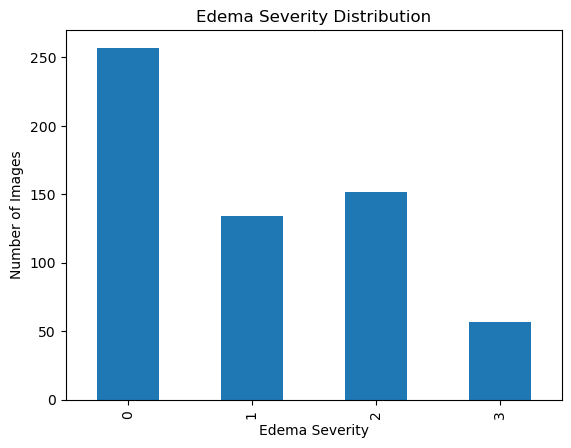

In [ ]:
'''Is our dataset balanced?'''

# Value counts and bar plot
severity_counts = df['edema_severity'].value_counts().sort_index()
severity_counts.plot(kind='bar', title='Edema Severity Distribution')
plt.xlabel('Edema Severity')
plt.ylabel('Number of Images')
plt.show()

🎯  ***Food for Thought***

What is the effect of class imbalance on training models? What ways can we implement to control it?

In [ ]:
''' Check for missing values and duplicates '''

# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

# Check for duplicate images
print("Duplicate dicom_ids:", df['dicom_id'].duplicated().sum())


🎯  ***Food for Thought***
- Why is it important to check how many patients vs. images we have?
- If one patient has multiple images with different severity scores, what does that mean clinically? How would you use it for training?
- What problems can arise from ignoring the patient-level grouping?

## Task 2: Visual Inspection and Raw Image Loading

In [ ]:
#Read DICOM Image

def read_dicom_image(row, image_folder ='/content/mimic-cxr-subset-summer-school/mimic-cxr-subset-summer-school'):
    """Read a DICOM image and return the pixel array."""
    patient_id = f"p{row['subject_id']}"
    study_id = f"s{row['study_id']}"
    #first two digits of the patient_id
    patient_folder = f"p{str(row['subject_id'])[:2]}"

    dicom_path = os.path.join(image_folder, patient_folder, patient_id, study_id, f"{row['dicom_id']}.dcm")
    ds = pydicom.dcmread(dicom_path)
    return ds

In [ ]:
# Select a sample of 2 images per edema severity class
samples = df.groupby('edema_severity').apply(lambda x: x.sample(2, random_state=42)).reset_index(drop=True)
samples

,subject_id,study_id,dicom_id,edema_severity,fold
0,19931942,58636003,398465df-9e296e04-30c90ec7-afaba643-34be5488,0,5
1,10761861,53507372,024760d7-a52289bb-3aa7d8d5-7561ec33-5af99870,0,5
2,11625397,51233665,a929fdc2-9487ef9e-73e0d9da-4c493d0e-efacf336,1,3
3,16409112,57225097,ae1cb80d-a466d5e7-effab4a8-b36272e6-f6cd8d01,1,3
4,15812823,51070607,92235d79-3bb8a378-f503c66c-9b8c3d7a-c7d42926,2,TEST
5,11615169,55227980,a38dabe4-ab617bed-e49edcd6-0f0a722f-2dc71e68,2,1
6,10253803,55814412,63bb5bfa-88f93af9-b9d2e5d1-836e6797-aa7881af,3,1
7,12152816,57441659,9e560382-436cf924-43f75054-3c66e1bc-b8a3f06e,3,2


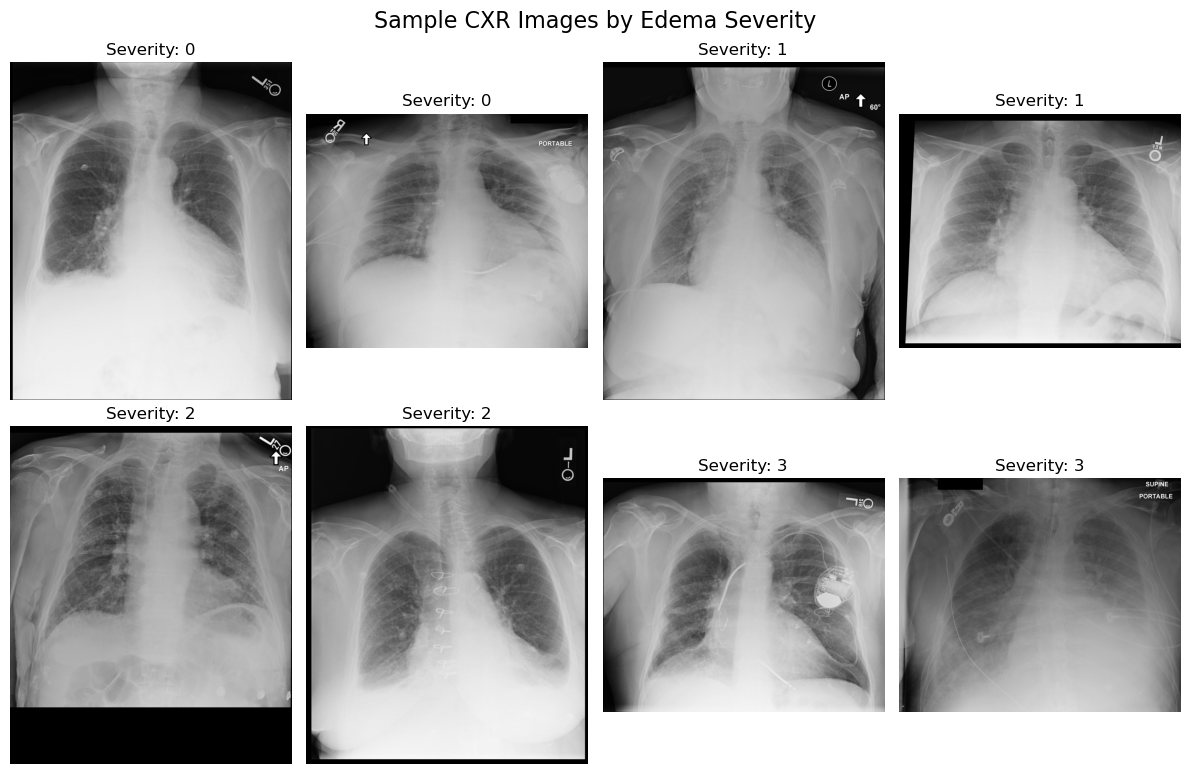

In [ ]:
# Set path to image folder
image_folder = '/content/mimic-cxr-subset-summer-school/mimic-cxr-subset-summer-school/' ##CHANGE THIS TO YOUR LOCAL PATH IF NECESSARY

# Plot samples
plt.figure(figsize=(12, 8))

for idx, row in samples.iterrows():
    ds = read_dicom_image(row, image_folder)
    img = ds.pixel_array

    plt.subplot(2, 4, idx + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Severity: {row['edema_severity']}")
    plt.axis('off')

plt.suptitle("Sample CXR Images by Edema Severity", fontsize=16)
plt.tight_layout()
plt.show()


Now, let us explore the **pixel intensities**!

Pixel intensities represent the brightness values in a medical image, where each number corresponds to how much radiation passed through the body at that point. Checking pixel intensities helps us understand image contrast, detect outliers, and decide on normalization or clipping strategies before training a model.

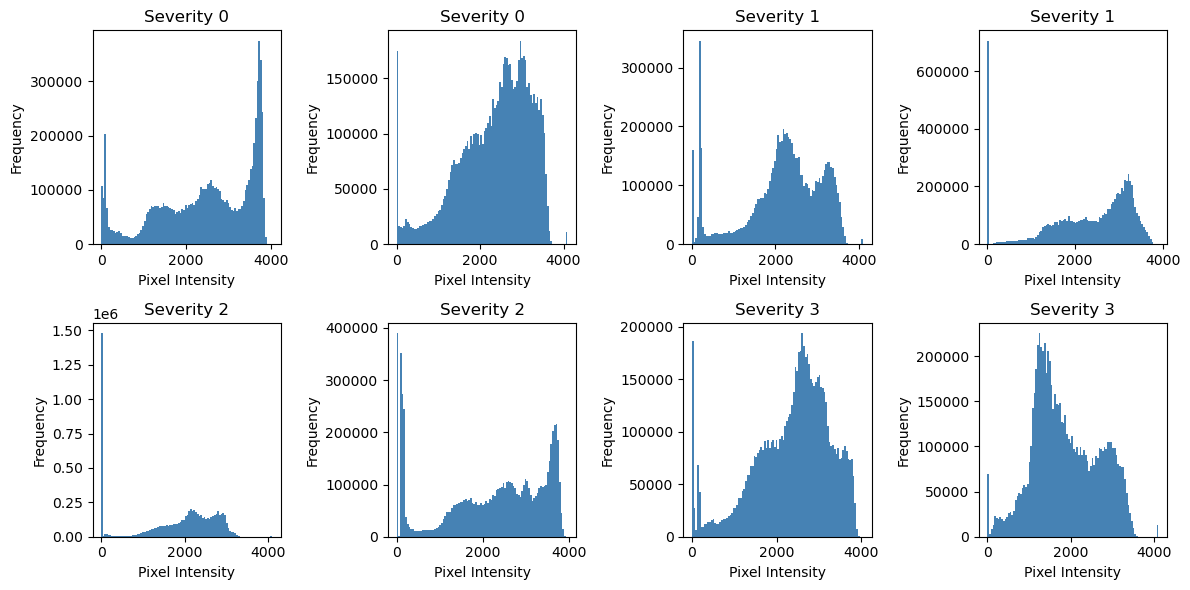

In [ ]:

plt.figure(figsize=(12, 6))

for i, row in samples.iterrows():

    ds = read_dicom_image(row, image_folder)
    img = ds.pixel_array.astype(np.float32)

    plt.subplot(2, 4, i + 1)
    plt.hist(img.ravel(), bins=100, color='steelblue')
    plt.title(f"Severity {row['edema_severity']}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    if i >= 7:
        break  # Only show 8 samples max

plt.tight_layout()
plt.show()

Do you see how the pixel intensity distributions vary across different edema severity classes? This can help us understand how edema severity might affect the pixel intensity distribution in CXR images.

Now, we should apply clipping to these images! Clipping is used to remove extreme pixel values that may be due to noise or artifacts and can negatively affect model training. We can perform clipping using either a percentile-based approach (e.g., keeping the central 99% of values) or by setting a fixed intensity range.

In [ ]:
def clip_percentile(image, lower=0.5, upper=99):
    image = image.astype(np.float32)
    low_val = np.percentile(image, lower)
    high_val = np.percentile(image, upper)
    print(f"Clipping range: {low_val:.2f} to {high_val:.2f}")
    return np.clip(image, low_val, high_val)



def clip_fixed(image, min_val=0, max_val=3000):
    return np.clip(image, min_val, max_val)


Clipping range: 0.00 to 3825.00
Clipping range: 0.00 to 3590.00
Clipping range: 0.00 to 3579.00
Clipping range: 0.00 to 3649.00


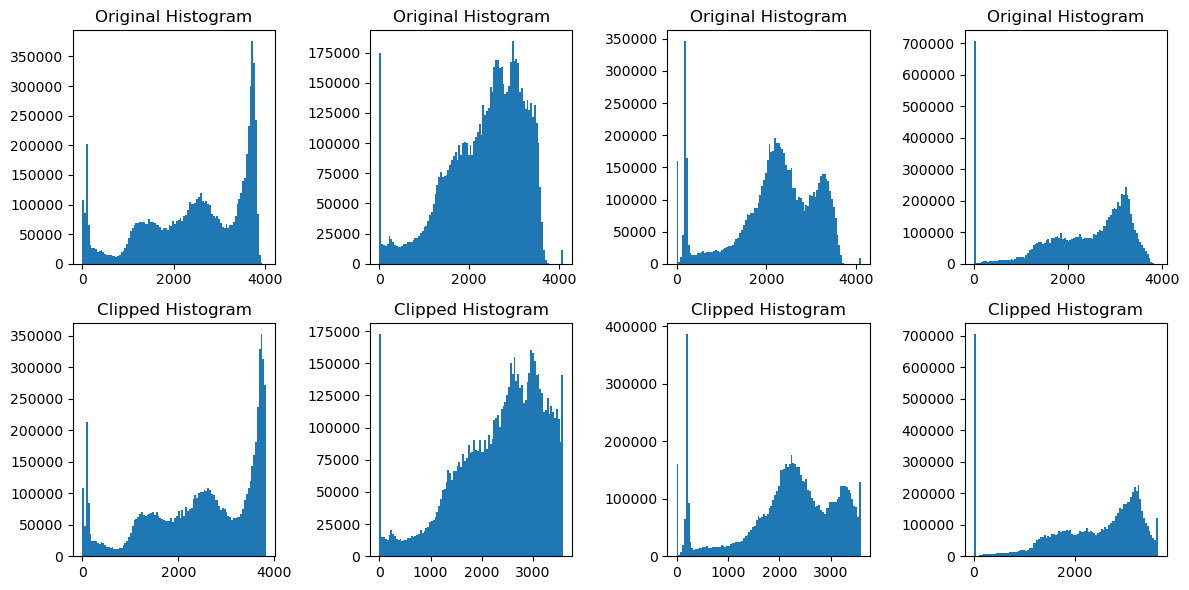

In [ ]:
'''Now, let's visualize the pixel intensity distributions before and after clipping. We will use the first 4 samples from our previous selection.'''

plt.figure(figsize=(12, 6))

for i, row in samples.head(4).iterrows():
    ds = read_dicom_image(row, image_folder)
    img = ds.pixel_array.astype(np.float32)

    # Apply percentile clipping
    clipped = clip_percentile(img)

    # Plot histograms
    plt.subplot(2, 4, i + 1)
    plt.hist(img.ravel(), bins=100)
    plt.title("Original Histogram")

    plt.subplot(2, 4, i + 5)
    plt.hist(clipped.ravel(), bins=100)
    plt.title("Clipped Histogram")

plt.tight_layout()
plt.show()


Clipping range: 0.00 to 3728.00


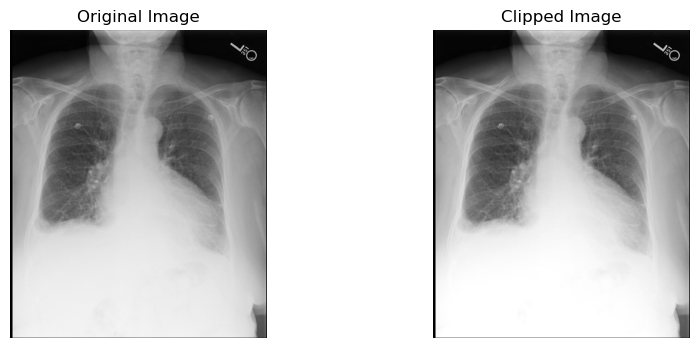

In [ ]:
'''Let's visualize the original and clipped images side-by-side for the first sample.'''

row = samples.iloc[0]
ds = read_dicom_image(row, image_folder)
img = ds.pixel_array

clipped = clip_percentile(img, lower=0.5, upper=90)

# Plot side-by-side
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(clipped, cmap='gray')
plt.title("Clipped Image")
plt.axis('off')
plt.show()


After clipping, we will rescale to a unit range. Rescaling to a unit range (e.g., [0, 1]) ensures that all images have consistent intensity scales, which helps models learn more effectively and speeds up convergence. It also prevents large pixel values from dominating gradients during training.

Common rescaling ranges include:

- [0, 1] — standard for most deep learning models using normalized inputs.
- [-1, 1] — often used when inputs are centered, especially with tanh activations.
- [0, 255] — used when saving or displaying images in 8-bit format.

In [ ]:
'''Now, let us rescale the image to a unit range. The following function rescales the image according to the minimum and maximum pixel values.
If the image has no variation (i.e., all pixels have the same value), it returns an array of zeros.'''

def rescale_to_unit_range(image):
    min_val = np.min(image)
    max_val = np.max(image)
    if max_val - min_val == 0:
        return np.zeros_like(image)
    return (image - min_val) / (max_val - min_val)


Clipping range: 0.00 to 3825.00


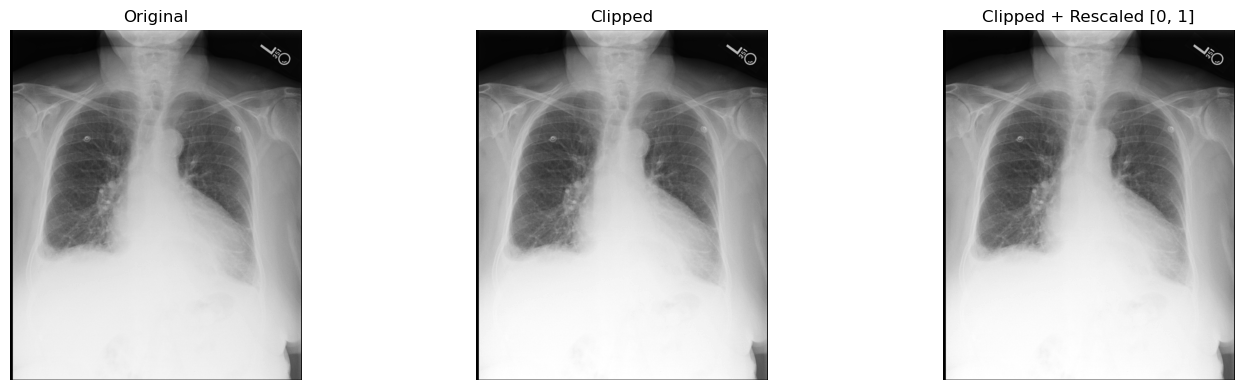

In [ ]:
'''Now, let's visualize the original, clipped, and rescaled images side-by-side for the first sample.'''

row = samples.iloc[0]
ds = read_dicom_image(row, image_folder)
img = ds.pixel_array.astype(np.float32)

# Apply clipping and rescaling
clipped = clip_percentile(img)
rescaled = rescale_to_unit_range(clipped)

# Plot
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(clipped, cmap='gray')
plt.title("Clipped")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(rescaled, cmap='gray')
plt.title("Clipped + Rescaled [0, 1]")
plt.axis('off')

plt.tight_layout()
plt.show()


🎯  ***Food for Thought***

- What happens to image contrast after clipping?
- Why might we prefer percentile clipping over fixed thresholds?
- How can clipping improve training stability?

## Task 3: Resize and Normalize CXR Images

Prior to feeding images to machine learning models, they should be resized. Resizing ensures all images have the same shape, and since ML models expect fixed-size inputs, think of it like making sure every puzzle piece fits into the model’s input slot! Without resizing, the model simply would not know how to process the image.

In [ ]:
import cv2

def preprocess_image(image, size=(224, 224), clip=True, rescale=True):
    image = image.astype(np.float32)

    if clip:
        image = clip_percentile(image)

    if rescale:
        image = rescale_to_unit_range(image)

    # Resize to target size using OpenCV
    resized = cv2.resize(image, size, interpolation=cv2.INTER_AREA)

    return resized


Clipping range: 0.00 to 3825.00
Clipping range: 0.00 to 3590.00
Clipping range: 0.00 to 3579.00
Clipping range: 0.00 to 3649.00
Clipping range: 0.00 to 3179.00
Clipping range: 0.00 to 3805.00
Clipping range: 0.00 to 3810.00
Clipping range: 0.00 to 3386.00


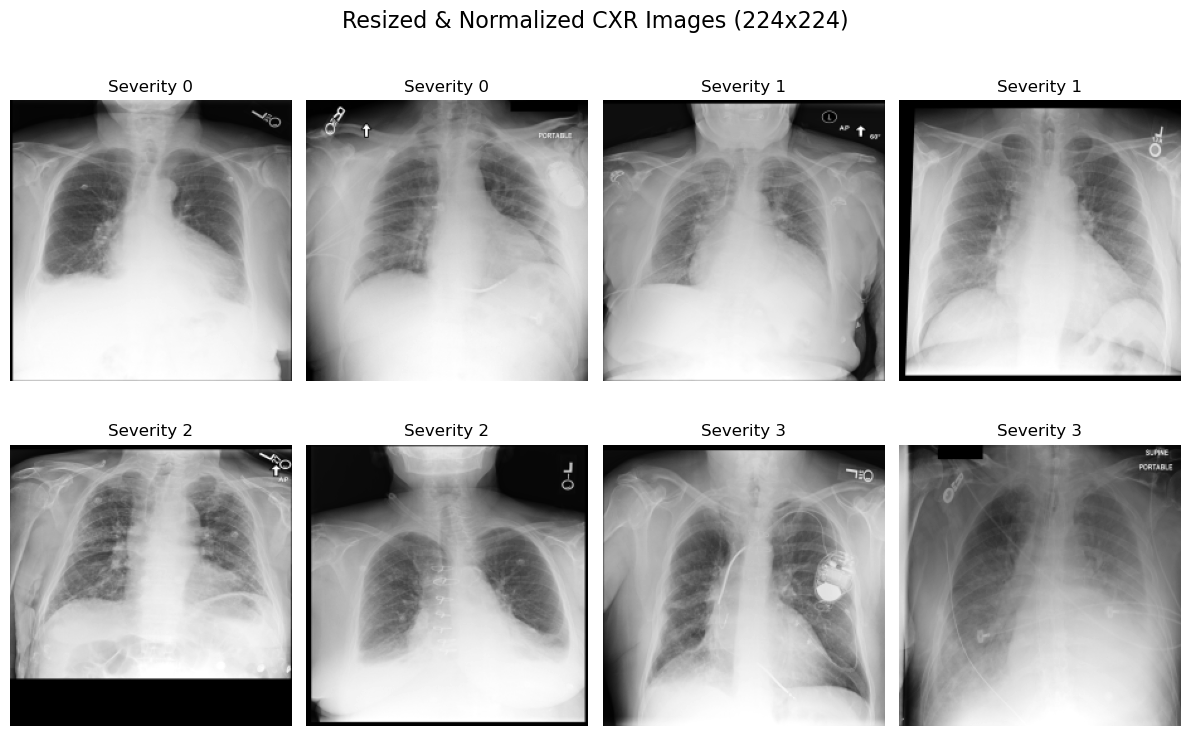

In [ ]:
plt.figure(figsize=(12, 8))

for i, row in samples.head(8).iterrows():
    ds = read_dicom_image(row, image_folder)
    img = ds.pixel_array

    processed = preprocess_image(img)

    plt.subplot(2, 4, i + 1)
    plt.imshow(processed, cmap='gray')
    plt.title(f"Severity {row['edema_severity']}")
    plt.axis('off')

plt.suptitle("Resized & Normalized CXR Images (224x224)", fontsize=16)
plt.tight_layout()
plt.show()


🎯  ***Food for Thought***

- Why do we need all images to be the same size?
- What is the tradeoff between 224×224 vs. 512×512?
- Why might we normalize to [0, 1] instead of standardizing?

In [ ]:
#Optional: Convert image to tensor for PyTorch
import torch

def image_to_tensor(image):
    # Add channel dimension: (1, H, W)
    return torch.tensor(image).unsqueeze(0).float()

## Task 4: Data Augmentation for CXR images

Next, we move to data augmentations. We augment data to help the model see different versions of the same image, like flipping, rotating, or changing brightness — so it learns to focus on the important patterns, not just the exact layout. This makes the model more robust and improves its ability to generalize to new, unseen data.

In [ ]:
# Define training augmentations
aug_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5),  # ±10 degrees
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.4),
])

/home/shahad.hardan/miniconda3/envs/chestxray_joint_new/lib/python3.8/site-packages/pydantic/main.py:212: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


Clipping range: 0.00 to 3825.00


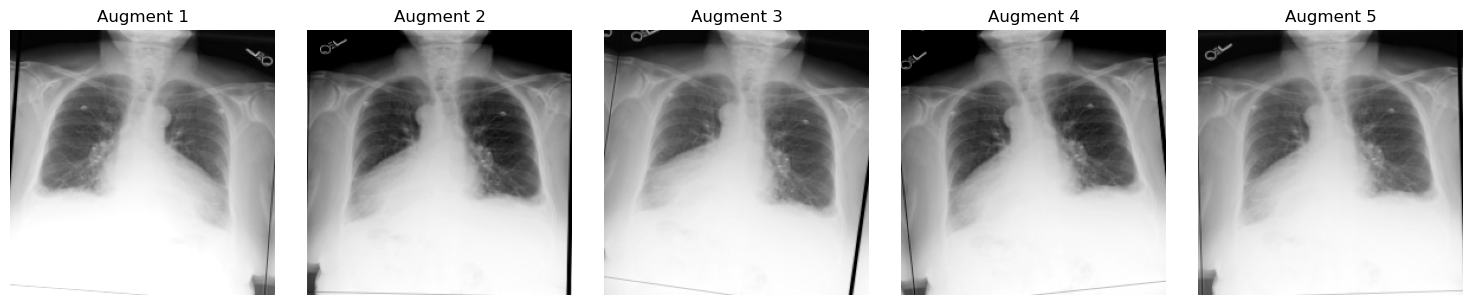

In [ ]:
def augment_and_plot(image, transform, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        augmented = transform(image=image)['image']
        plt.subplot(1, n, i + 1)
        plt.imshow(augmented, cmap='gray')
        plt.axis('off')
        plt.title(f'Augment {i+1}')
    plt.tight_layout()
    plt.show()

# Load and preprocess one image
row = samples.iloc[0]
ds = read_dicom_image(row, image_folder)
img = ds.pixel_array

preprocessed = preprocess_image(img)  # from Task 3

# Convert to 8-bit image for augmentation (albumentations expects HxW uint8)
image_uint8 = (preprocessed * 255).astype('uint8')

augment_and_plot(image_uint8, aug_transform, n=5)


🎯  ***Food for Thought***

- Which augmentations are realistic for CXR? Which ones might be harmful?
- Why don’t we apply vertical flip?
- When should we apply augmentations (training vs. validation)?

## Task 5: Building a Pytorch Dataset for CXR Edema Classification

Now that we have all the necessary steps, let us build a dataset class!

We build a custom Dataset class in PyTorch to organize how images and labels are loaded, preprocessed, and fed into the model. It gives us full control over loading DICOM files, applying transforms, and ensuring the data is ready for training in batches. If you are not familiar with PyTorch, it is a popular deep learning library that lets you build and train neural networks with flexibility and ease.



In [ ]:
import torch
from torch.utils.data import Dataset
import pydicom
import cv2
import os

class CXRDataset(Dataset):
    def __init__(self, df, image_folder, transform=None, image_size=(224, 224), training=True):
        self.df = df.reset_index(drop=True)
        self.folder = image_folder
        self.transform = transform
        self.image_size = image_size
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        patient_id = f"p{row['subject_id']}"
        study_id = f"s{row['study_id']}"
        #first two digits of the patient_id
        patient_folder = f"p{str(row['subject_id'])[:2]}"
        dicom_path = os.path.join(self.folder, patient_folder, patient_id, study_id, f"{row['dicom_id']}.dcm")
        ds = pydicom.dcmread(dicom_path)
        image = ds.pixel_array.astype(np.float32)

        # Preprocessing: clip, rescale, resize
        image = clip_percentile(image)
        image = rescale_to_unit_range(image)
        image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_AREA)

        # Convert to uint8 for albumentations
        if self.transform:
            image = (image * 255).astype('uint8')
            image = self.transform(image=image)['image']  # transform returns dict
            image = torch.tensor(image).unsqueeze(0).float() / 255.0
            image = image.float() / 255.0  # Back to float in [0, 1]
        else:
            image = torch.tensor(image).unsqueeze(0).float()  # (1, H, W)

        label = torch.tensor(row['edema_severity'], dtype=torch.long)

        return image, label


In [ ]:
from sklearn.model_selection import GroupShuffleSplit

'''GroupShuffleSplit is used to ensure that images from the same patient are not split between training and validation sets.'''

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(df, groups=df['subject_id']))

df_train = df.iloc[train_idx]
df_val = df.iloc[val_idx]

In [ ]:
df_train

,subject_id,study_id,dicom_id,edema_severity,fold
1,10130348,57511959,c23640ba-9a3fc83e-df6f06f2-9244d819-275ef0b3,0,1
2,10154271,51768020,c92820ab-86ca072a-cb979fed-e8a9b8f0-2e1b4472,1,2
3,10170334,50465091,41eb4980-c532d3f5-25e1b923-6696c9fa-b9e26262,0,3
6,10251182,53163573,c96a3609-3ccd0269-9d55c79c-b794bca9-7bb6715f,0,4
7,10253803,55814412,63bb5bfa-88f93af9-b9d2e5d1-836e6797-aa7881af,3,1
...,...,...,...,...,...
593,12764402,54064800,081e279e-b0923a53-2c04878a-f759b071-2c0e1da9,0,TEST
594,12764402,54064800,8f52c156-7407bf97-ec66fc0e-141c5c9a-e4e06074,0,TEST
595,12995867,54694807,95adeb4b-e940fba6-458c5da2-3c3183f0-5ee010b5,0,2
596,13005295,52445498,3c5a1051-8b9abbe3-dba58167-8fc77605-0df66051,0,3


In [ ]:
from torch.utils.data import DataLoader

'''Now we will create DataLoaders for training and validation datasets. DataLoaders are used to efficiently load data in batches during
training and validation.'''

# Use the same transform from Task 4
train_dataset = CXRDataset(df_train, image_folder, transform=aug_transform, training=True)
val_dataset = CXRDataset(df_val, image_folder, transform=None, training=False)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

Clipping range: 0.00 to 3707.00
Clipping range: 0.00 to 3316.00
Clipping range: 0.00 to 3579.00
Clipping range: 108.00 to 3910.00
Clipping range: 0.00 to 3515.00
Clipping range: 0.00 to 3884.00
Clipping range: 0.00 to 3706.00
Clipping range: 86.00 to 3895.00


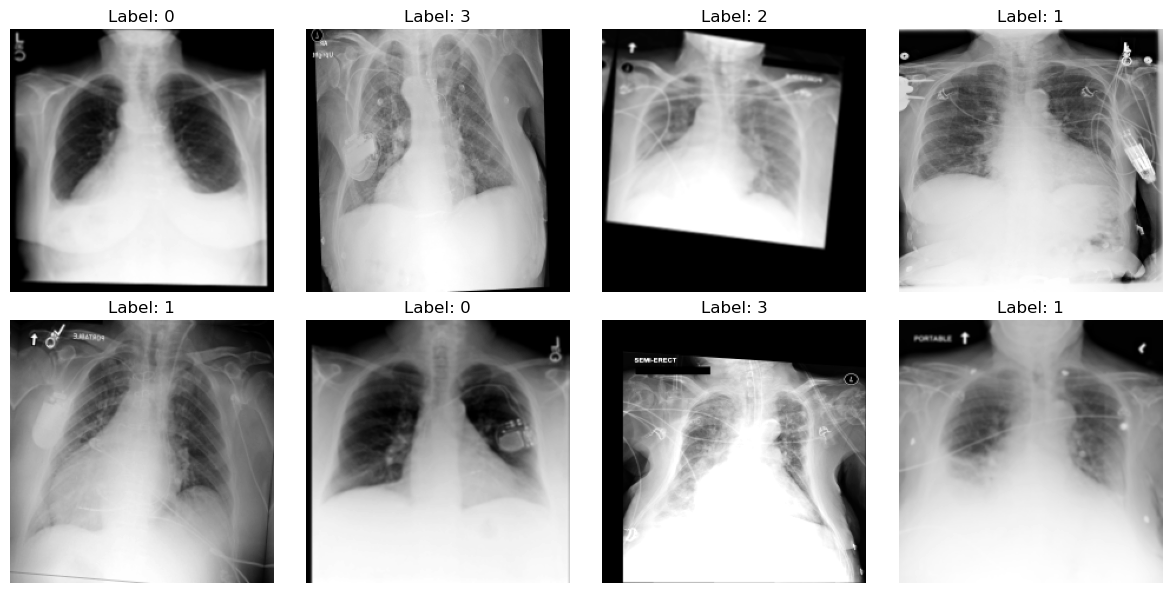

In [ ]:
'''Let's visualize some images from the training DataLoader to ensure everything is working correctly.'''

images, labels = next(iter(train_loader))

plt.figure(figsize=(12, 6))
for i in range(len(images)):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()


🎯  ***Food for Thought***

- Why is patient-level splitting important in medical data?
- What does the Dataset return? How does it integrate with models?
- What happens if we skip normalization or augmentation?

## Task 6: Traditional Feature Extraction from CXR Images

**Traditional feature extraction methods**, like ORB and GLCM, are used to capture patterns, textures, and shapes in medical images using hand-crafted techniques. They were widely used before deep learning and are still helpful when working with small datasets or when interpretability is important.

Deep learning models now automatically learn powerful features directly from images, often outperforming traditional methods , but handcrafted features can still be useful in hybrid systems or for validation.

**Now, let us start with the ORB method!**

ORB (Oriented FAST and Rotated BRIEF) is a feature extraction method used to detect keypoints in an image (areas with sharp changes like edges or corners) and describe them with compact numeric vectors. These features can be used to match similar regions across images or recognize patterns. ORB is fast, rotation-invariant, and widely used in traditional computer vision tasks like image matching or retrieval.

In [ ]:
import cv2

def show_orb_keypoints(image, title='ORB Keypoints'):
    orb = cv2.ORB_create(nfeatures=200)
    keypoints = orb.detect(image, None)
    keypoints, descriptors = orb.compute(image, keypoints)

    img_kp = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)

    plt.figure(figsize=(6, 6))
    plt.imshow(img_kp, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

    return descriptors


Clipping range: 0.00 to 3825.00


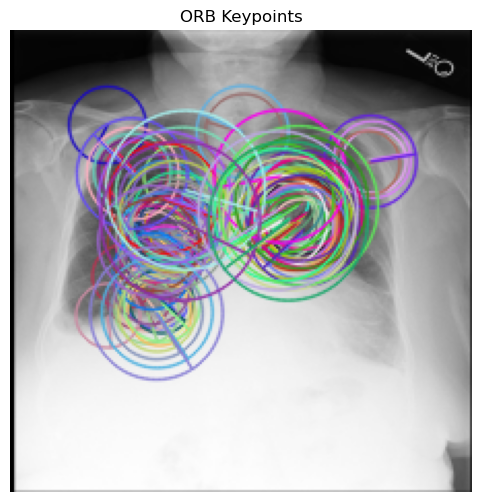

ORB descriptor shape: (92, 32)


In [ ]:
# Load and preprocess one image
row = samples.iloc[0]
ds = read_dicom_image(row, image_folder)
img = ds.pixel_array
img = preprocess_image(img)
img_uint8 = (img * 255).astype('uint8')

descriptors = show_orb_keypoints(img_uint8)
print(f"ORB descriptor shape: {descriptors.shape if descriptors is not None else 'None'}")

**Then, let us move to GLCM!**

GLCM (Gray Level Co-occurrence Matrix) is a texture analysis method that calculates how often pairs of pixel intensities occur in specific spatial relationships. From this matrix, we can extract texture features such as contrast, energy, homogeneity, and correlation. GLCM is particularly useful in medical imaging to capture tissue patterns and subtle differences in image texture.

In [ ]:
from skimage.feature import graycomatrix, graycoprops

def extract_glcm_features(image, distances=[1], angles=[0], levels=256):
    image = (image * 255).astype('uint8')  # GLCM expects uint8
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)

    features = {
        'contrast': graycoprops(glcm, 'contrast')[0, 0],
        'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
        'energy': graycoprops(glcm, 'energy')[0, 0],
        'correlation': graycoprops(glcm, 'correlation')[0, 0],
    }
    return features

glcm_feats = extract_glcm_features(img)
print("GLCM Texture Features:")
for k, v in glcm_feats.items():
    print(f"  {k}: {v:.4f}")


GLCM Texture Features:
  contrast: 156.2035
  homogeneity: 0.4557
  energy: 0.0443
  correlation: 0.9855


🎯  ***Food for Thought***

- What do these features capture compared to deep features?
- Would these be useful in low-data regimes?
- How do we combine them with models (e.g., random forest, or hybrid CNN + GLCM)?

### Lung Region of Interest (Lung ROI)

The purpose of extracting a lung ROI (region of interest) is to focus the model only on the parts of the image that matter most, the lungs, while reducing noise from irrelevant areas like the ribs or background. This can help the model learn more efficiently and improve performance.

To give a bit more intuition, imagine you are trying to read a map of an entire country, but you are only interested in one small city. Looking at everything at once can be overwhelming, and the details you care about might get lost in all the noise. That’s exactly what happens with medical images.

In chest X-rays, for example, we often want to focus only on the lungs, because that’s where signs of disease usually appear. If we let the model look at the entire image, including the spine, ribs, or labels in the corners, it might get distracted and learn the wrong things.

So instead of giving it the full map, we crop out just the important part, **the Region of Interest (ROI)**, so the model can concentrate, learn faster, and perform better.


There are many automatic ways to extract ROIs, from rule-based methods to advanced deep learning models that can segment organs with high precision. But before jumping into complex tools, it's important to understand the basics.

In this notebook, we’ll start by exploring a **simple cropping approach** to isolate the lungs. Once you see how that works, you will be ready to experiment with more powerful deep learning-based methods later on!

In [ ]:
def center_crop_lung_heuristic(image, crop_ratio=0.1):
    h, w = image.shape
    top = int(h * crop_ratio)
    bottom = int(h * (1 - crop_ratio))
    left = int(w * crop_ratio)
    right = int(w * (1 - crop_ratio))
    return image[top:bottom, left:right]

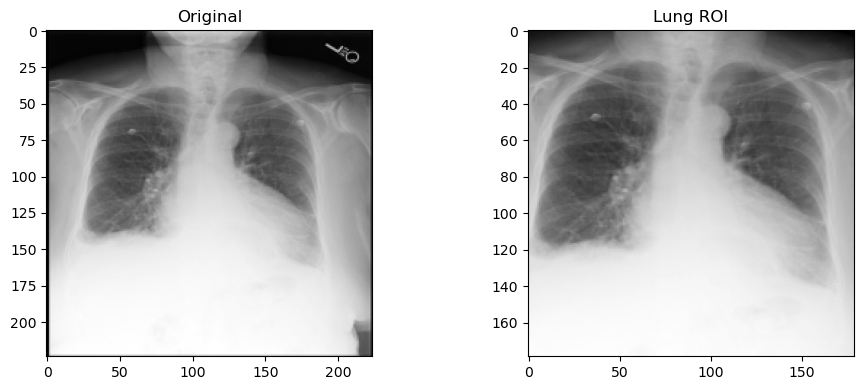

In [ ]:
# Load and preprocess image
img = ds.pixel_array.astype(np.float32) #using the same ds from previous cell
img = preprocess_image(img)  # clip + normalize + resize to e.g., 512x512
img_uint8 = (img * 255).astype('uint8')

roi = center_crop_lung_heuristic(img_uint8)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_uint8, cmap='gray')
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(roi, cmap='gray')
plt.title("Lung ROI")

plt.tight_layout()
plt.show()

Optional Extension:
Use a pretrained lung segmentation model (like from MONAI, TorchXRayVision, or pydicom-seg tools).